# Necessary Packages

In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
import shutil
from random import sample
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

2024-03-12 20:52:06.639582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 20:52:06.639690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 20:52:06.767031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Global

In [2]:
figures = {}
histories = {}
durations = {}
models = {}

# Data Loading

In [3]:
df = pd.read_csv("/kaggle/input/cifar10-python-in-csv/train.csv")

In [4]:
train_df,val_df = train_test_split(df,test_size=0.4)
val_df,test_df = train_test_split(val_df,test_size=0.5)

print(f"train_df = {len(train_df)}")
print(f"val_df = {len(val_df)}")
print(f"test_df = {len(test_df)}")

train_df = 30000
val_df = 10000
test_df = 10000


In [5]:
def preprocess(dfs):
    
    datasets = []
    
    for df in dfs:
        X = df.drop(columns=["label"]) / 255.0
        y = df["label"]
        
        X = tf.convert_to_tensor(X.values)
        y = tf.convert_to_tensor(y.values)
        
        datasets.append((X,y))
        
    return datasets

In [6]:
train_data,val_data,test_data = preprocess([
    train_df,
    val_df,
    test_df
])

# Architecture

In [7]:
def create_model(
    optimizer=None,
    drop_out_rate : float = 0.0,
    lambda_ : float = 0.0,
    batch_normalization : bool = False,
) -> tf.keras.models.Model:

  model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(
        units=64,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=lambda_)
    ),
  ])

  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization(synchronized=True))

  model.add(tf.keras.layers.Dropout(rate=drop_out_rate))
  model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))

  if optimizer is not None:
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy()
        ],
    )

  return model

# Training

In [8]:
def train(
    model,
    name,
    train_data,
    val_data,
    batch_size=32,
    epochs=50,
    callbacks=None,
    verbose='auto'
):

  tic = time.time()
  history = model.fit(
    x=train_data[0],
    y=train_data[1],
    validation_data=val_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=verbose
  )
  toc = time.time()

  duration = toc - tic

  print(f'Model took {duration:.3f} seconds to train.')

  models[name] = model
  histories[name] = history
  durations[name] = duration

## Mini batch SGD

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model = create_model(optimizer=optimizer)
train(model,
    name='Mini-Batch SGD',
    train_data=train_data,
    val_data=val_data,
)

Epoch 1/50
 90/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2453 - sparse_categorical_accuracy: 0.1604

I0000 00:00:1710276774.593233     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710276774.608358     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0608 - sparse_categorical_accuracy: 0.2442

W0000 00:00:1710276777.709114     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.0607 - sparse_categorical_accuracy: 0.2442 - val_loss: 1.8443 - val_sparse_categorical_accuracy: 0.3443
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8014 - sparse_categorical_accuracy: 0.3592 - val_loss: 1.7469 - val_sparse_categorical_accuracy: 0.3765
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7237 - sparse_categorical_accuracy: 0.3865 - val_loss: 1.7161 - val_sparse_categorical_accuracy: 0.3887
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6543 - sparse_categorical_accuracy: 0.4109 - val_loss: 1.7099 - val_sparse_categorical_accuracy: 0.3818
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6154 - sparse_categorical_accuracy: 0.4305 - val_loss: 1.6850 - val_sparse_categorical_accuracy: 0.3987
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5882 - sparse_categorical_accuracy: 0.4390 - val_loss: 1.6763 - val_sparse_categorical_accuracy: 0.4085
Epoch 7/50
938/

## Mini Batch SGD With Early Stopping

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model = create_model(optimizer=optimizer)
train(model,
    name='Mini-Batch SGD + Early Stopping',
    train_data=train_data,
    val_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            min_delta=0.001,
            patience=5,
            verbose=0
        )
    ]
)

Epoch 1/50
 95/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2330 - sparse_categorical_accuracy: 0.1812

W0000 00:00:1710276875.738473      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0601 - sparse_categorical_accuracy: 0.2493

W0000 00:00:1710276878.202985      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.0600 - sparse_categorical_accuracy: 0.2493 - val_loss: 1.8904 - val_sparse_categorical_accuracy: 0.2975
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8202 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.9048 - val_sparse_categorical_accuracy: 0.3172
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7313 - sparse_categorical_accuracy: 0.3862 - val_loss: 1.7614 - val_sparse_categorical_accuracy: 0.3767
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6711 - sparse_categorical_accuracy: 0.4099 - val_loss: 1.7469 - val_sparse_categorical_accuracy: 0.3811
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6316 - sparse_categorical_accuracy: 0.4226 - val_loss: 1.6276 - val_sparse_categorical_accuracy: 0.4194
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5912 - sparse_categorical_accuracy: 0.4376 - val_loss: 1.6350 - val_sparse_categorical_accuracy: 0.4244
Epoch 7/50
938/

## Mini batch SGD With L2 norm regularization

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model = create_model(optimizer=optimizer,lambda_=0.05)
train(model,
    name='Mini-Batch SGD With L2 Nomralization',
    train_data=train_data,
    val_data=val_data,
)

Epoch 1/50
 98/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3427 - sparse_categorical_accuracy: 0.1389

W0000 00:00:1710276933.494158     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9865 - sparse_categorical_accuracy: 0.2306

W0000 00:00:1710276936.117149     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.9854 - sparse_categorical_accuracy: 0.2306 - val_loss: 2.5910 - val_sparse_categorical_accuracy: 0.3354
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3755 - sparse_categorical_accuracy: 0.3305 - val_loss: 2.0161 - val_sparse_categorical_accuracy: 0.3354
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9678 - sparse_categorical_accuracy: 0.3434 - val_loss: 1.8822 - val_sparse_categorical_accuracy: 0.3530
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8760 - sparse_categorical_accuracy: 0.3575 - val_loss: 1.8450 - val_sparse_categorical_accuracy: 0.3610
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8258 - sparse_categorical_accuracy: 0.3714 - val_loss: 1.8344 - val_sparse_categorical_accuracy: 0.3592
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7988 - sparse_categorical_accuracy: 0.3805 - val_loss: 1.7907 - val_sparse_categorical_accuracy: 0.3667
Epoch 7/50
938/

## Mini Batch SGD With Dropout=0.2

In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model = create_model(optimizer=optimizer,drop_out_rate=0.2)
train(model,
    name='Mini-Batch SGD With Dropout Rate = 0.2',
    train_data=train_data,
    val_data=val_data,
)

Epoch 1/50
 94/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3134 - sparse_categorical_accuracy: 0.1210

W0000 00:00:1710277035.652785     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1173 - sparse_categorical_accuracy: 0.2177

W0000 00:00:1710277039.168577     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.1172 - sparse_categorical_accuracy: 0.2178 - val_loss: 1.8835 - val_sparse_categorical_accuracy: 0.3315
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8756 - sparse_categorical_accuracy: 0.3260 - val_loss: 1.8328 - val_sparse_categorical_accuracy: 0.3345
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8038 - sparse_categorical_accuracy: 0.3559 - val_loss: 1.8475 - val_sparse_categorical_accuracy: 0.3373
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7458 - sparse_categorical_accuracy: 0.3813 - val_loss: 1.7014 - val_sparse_categorical_accuracy: 0.3901
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7104 - sparse_categorical_accuracy: 0.3952 - val_loss: 1.6982 - val_sparse_categorical_accuracy: 0.3970
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6829 - sparse_categorical_accuracy: 0.3998 - val_loss: 1.6412 - val_sparse_categorical_accuracy: 0.4127
Epoch 7/50
938/

## Mini Batch SGD With Dropout=0.3

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model = create_model(optimizer=optimizer,drop_out_rate=0.3)
train(model,
    name='Mini-Batch SGD With Dropout Rate = 0.3',
    train_data=train_data,
    val_data=val_data,
)

Epoch 1/50
 96/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.1470

W0000 00:00:1710277140.843427      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1368 - sparse_categorical_accuracy: 0.2158

W0000 00:00:1710277144.453710     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.1367 - sparse_categorical_accuracy: 0.2159 - val_loss: 1.8959 - val_sparse_categorical_accuracy: 0.3279
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9048 - sparse_categorical_accuracy: 0.3205 - val_loss: 1.8344 - val_sparse_categorical_accuracy: 0.3345
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8216 - sparse_categorical_accuracy: 0.3494 - val_loss: 1.7802 - val_sparse_categorical_accuracy: 0.3647
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7770 - sparse_categorical_accuracy: 0.3675 - val_loss: 1.7132 - val_sparse_categorical_accuracy: 0.3956
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7374 - sparse_categorical_accuracy: 0.3845 - val_loss: 1.6899 - val_sparse_categorical_accuracy: 0.4025
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6889 - sparse_categorical_accuracy: 0.3957 - val_loss: 1.6397 - val_sparse_categorical_accuracy: 0.4162
Epoch 7/50
938/

## Mini Batch SGD With Dropout=0.5

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model = create_model(optimizer=optimizer,drop_out_rate=0.5)
train(model,
    name='Mini-Batch SGD With Dropout Rate = 0.5',
    train_data=train_data,
    val_data=val_data,
)

Epoch 1/50
 97/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3249 - sparse_categorical_accuracy: 0.1325

W0000 00:00:1710277246.212178     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1911 - sparse_categorical_accuracy: 0.1836

W0000 00:00:1710277249.746556      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.1910 - sparse_categorical_accuracy: 0.1836 - val_loss: 1.9312 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9725 - sparse_categorical_accuracy: 0.2864 - val_loss: 1.8350 - val_sparse_categorical_accuracy: 0.3531
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8923 - sparse_categorical_accuracy: 0.3219 - val_loss: 1.7931 - val_sparse_categorical_accuracy: 0.3578
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8474 - sparse_categorical_accuracy: 0.3389 - val_loss: 1.7997 - val_sparse_categorical_accuracy: 0.3448
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8101 - sparse_categorical_accuracy: 0.3536 - val_loss: 1.7238 - val_sparse_categorical_accuracy: 0.3905
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7828 - sparse_categorical_accuracy: 0.3644 - val_loss: 1.7090 - val_sparse_categorical_accuracy: 0.3869
Epoch 7/50
938/

## Mini Batch SGD With Batch Normalization

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model = create_model(optimizer=optimizer,batch_normalization=True)
train(model,
    name='Mini-Batch SGD With Batch Normalization',
    train_data=train_data,
    val_data=val_data,
)

Epoch 1/50
 95/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2365 - sparse_categorical_accuracy: 0.2299

W0000 00:00:1710277351.571516     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9626 - sparse_categorical_accuracy: 0.3073

W0000 00:00:1710277354.412401      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.9625 - sparse_categorical_accuracy: 0.3073 - val_loss: 1.9083 - val_sparse_categorical_accuracy: 0.3317
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7378 - sparse_categorical_accuracy: 0.3897 - val_loss: 1.8839 - val_sparse_categorical_accuracy: 0.3267
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6707 - sparse_categorical_accuracy: 0.4128 - val_loss: 1.7339 - val_sparse_categorical_accuracy: 0.3822
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6157 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.6957 - val_sparse_categorical_accuracy: 0.4081
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5705 - sparse_categorical_accuracy: 0.4467 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.4062
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5250 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.6370 - val_sparse_categorical_accuracy: 0.4251
Epoch 7/50
938/

## Random Search

In [16]:
def objective(trial : optuna.trial.Trial):

  lr = trial.suggest_float("lr", low=0.001,high=0.1,log=True)
  dropout_rate = trial.suggest_float("dropout_rate", low=0.2,high=0.6,log=True)
  batch_size = trial.suggest_categorical("batch_size", choices=[16,32,64,128])

  optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
  model = create_model(
      optimizer=optimizer,
      drop_out_rate=dropout_rate,
  )

  print(f"lr = {lr},dropout_rate = {dropout_rate},batch_size = {batch_size}")

  train(model,
      name='Random Search',
      train_data=train_data,
      val_data=val_data,
      verbose=0,
      batch_size=batch_size
  )

  loss, accuracy = model.evaluate(val_data[0],val_data[1])

  return accuracy

In [17]:
study = optuna.create_study(direction="maximize")

[I 2024-03-12 21:04:16,421] A new study created in memory with name: no-name-0b08dafb-2567-43a3-834e-4c2293f14cff


In [18]:
study.optimize(func=objective,n_trials=20)

lr = 0.045919882911051556,dropout_rate = 0.4482451610258203,batch_size = 32


W0000 00:00:1710277459.478531     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710277462.957107      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model took 99.489 seconds to train.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7449 - sparse_categorical_accuracy: 0.4026


[I 2024-03-12 21:05:56,770] Trial 0 finished with value: 0.39800000190734863 and parameters: {'lr': 0.045919882911051556, 'dropout_rate': 0.4482451610258203, 'batch_size': 32}. Best is trial 0 with value: 0.39800000190734863.


lr = 0.003415080812938203,dropout_rate = 0.433990781281712,batch_size = 128
Model took 39.214 seconds to train.
104/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6094 - sparse_categorical_accuracy: 0.4269  

W0000 00:00:1710277596.554039      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6250 - sparse_categorical_accuracy: 0.4218


[I 2024-03-12 21:06:37,018] Trial 1 finished with value: 0.41999998688697815 and parameters: {'lr': 0.003415080812938203, 'dropout_rate': 0.433990781281712, 'batch_size': 128}. Best is trial 1 with value: 0.41999998688697815.


lr = 0.0019389870921142612,dropout_rate = 0.20198084712318837,batch_size = 128
Model took 38.208 seconds to train.
103/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6376 - sparse_categorical_accuracy: 0.4263  

W0000 00:00:1710277635.804626     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6506 - sparse_categorical_accuracy: 0.4228


[I 2024-03-12 21:07:16,280] Trial 2 finished with value: 0.4207000136375427 and parameters: {'lr': 0.0019389870921142612, 'dropout_rate': 0.20198084712318837, 'batch_size': 128}. Best is trial 2 with value: 0.4207000136375427.


lr = 0.023929306397866907,dropout_rate = 0.24479067496258025,batch_size = 64
Model took 58.984 seconds to train.
102/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4114 - sparse_categorical_accuracy: 0.4985  

W0000 00:00:1710277695.852002      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4383 - sparse_categorical_accuracy: 0.4914


[I 2024-03-12 21:08:16,327] Trial 3 finished with value: 0.48840001225471497 and parameters: {'lr': 0.023929306397866907, 'dropout_rate': 0.24479067496258025, 'batch_size': 64}. Best is trial 3 with value: 0.48840001225471497.


lr = 0.004338513458334932,dropout_rate = 0.35518989065467266,batch_size = 16
Model took 183.501 seconds to train.
100/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3753 - sparse_categorical_accuracy: 0.5137  

W0000 00:00:1710277880.542535      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3972 - sparse_categorical_accuracy: 0.5058


[I 2024-03-12 21:11:21,277] Trial 4 finished with value: 0.5024999976158142 and parameters: {'lr': 0.004338513458334932, 'dropout_rate': 0.35518989065467266, 'batch_size': 16}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.012829342764977754,dropout_rate = 0.2636065571621673,batch_size = 64
Model took 58.381 seconds to train.
102/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4418 - sparse_categorical_accuracy: 0.4903  

W0000 00:00:1710277940.241691      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4557 - sparse_categorical_accuracy: 0.4883


[I 2024-03-12 21:12:20,803] Trial 5 finished with value: 0.48579999804496765 and parameters: {'lr': 0.012829342764977754, 'dropout_rate': 0.2636065571621673, 'batch_size': 64}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.005410108019521303,dropout_rate = 0.22791109770449705,batch_size = 32


W0000 00:00:1710277943.881036      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710277947.312318      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model took 99.638 seconds to train.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4286 - sparse_categorical_accuracy: 0.4965


[I 2024-03-12 21:14:01,338] Trial 6 finished with value: 0.49300000071525574 and parameters: {'lr': 0.005410108019521303, 'dropout_rate': 0.22791109770449705, 'batch_size': 32}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.015495123528291998,dropout_rate = 0.4335083303366494,batch_size = 128
Model took 37.776 seconds to train.
104/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6804 - sparse_categorical_accuracy: 0.4101  

W0000 00:00:1710278079.695976      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6867 - sparse_categorical_accuracy: 0.4096


[I 2024-03-12 21:14:40,174] Trial 7 finished with value: 0.4066999852657318 and parameters: {'lr': 0.015495123528291998, 'dropout_rate': 0.4335083303366494, 'batch_size': 128}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.005991492432121162,dropout_rate = 0.48346864596073263,batch_size = 128
Model took 37.554 seconds to train.
105/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5771 - sparse_categorical_accuracy: 0.4371  

W0000 00:00:1710278118.307019      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5944 - sparse_categorical_accuracy: 0.4350


[I 2024-03-12 21:15:18,775] Trial 8 finished with value: 0.4352000057697296 and parameters: {'lr': 0.005991492432121162, 'dropout_rate': 0.48346864596073263, 'batch_size': 128}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.02514805825276205,dropout_rate = 0.3764762568598376,batch_size = 64
Model took 58.552 seconds to train.
103/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4392 - sparse_categorical_accuracy: 0.4889  

W0000 00:00:1710278177.907863     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4620 - sparse_categorical_accuracy: 0.4855


[I 2024-03-12 21:16:18,390] Trial 9 finished with value: 0.48170000314712524 and parameters: {'lr': 0.02514805825276205, 'dropout_rate': 0.3764762568598376, 'batch_size': 64}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.001050879435422616,dropout_rate = 0.30923356231713717,batch_size = 16
Model took 181.575 seconds to train.
104/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4841 - sparse_categorical_accuracy: 0.4657  

W0000 00:00:1710278360.665875      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4978 - sparse_categorical_accuracy: 0.4669


[I 2024-03-12 21:19:21,382] Trial 10 finished with value: 0.46860000491142273 and parameters: {'lr': 0.001050879435422616, 'dropout_rate': 0.30923356231713717, 'batch_size': 16}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.005439028658606001,dropout_rate = 0.32569689176621575,batch_size = 32


W0000 00:00:1710278364.980114     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710278368.463695     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model took 99.544 seconds to train.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4219 - sparse_categorical_accuracy: 0.4901


[I 2024-03-12 21:21:01,815] Trial 11 finished with value: 0.492000013589859 and parameters: {'lr': 0.005439028658606001, 'dropout_rate': 0.32569689176621575, 'batch_size': 32}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.0029860698378444974,dropout_rate = 0.5584806773177011,batch_size = 16
Model took 178.894 seconds to train.
101/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4802 - sparse_categorical_accuracy: 0.4794  

W0000 00:00:1710278641.440089     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5016 - sparse_categorical_accuracy: 0.4723


[I 2024-03-12 21:24:02,506] Trial 12 finished with value: 0.4666000008583069 and parameters: {'lr': 0.0029860698378444974, 'dropout_rate': 0.5584806773177011, 'batch_size': 16}. Best is trial 4 with value: 0.5024999976158142.


lr = 0.007457793903840216,dropout_rate = 0.26595616642805986,batch_size = 16
Model took 178.578 seconds to train.
105/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3920 - sparse_categorical_accuracy: 0.5110  

W0000 00:00:1710278821.793759      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4118 - sparse_categorical_accuracy: 0.5074


[I 2024-03-12 21:27:02,472] Trial 13 finished with value: 0.5038999915122986 and parameters: {'lr': 0.007457793903840216, 'dropout_rate': 0.26595616642805986, 'batch_size': 16}. Best is trial 13 with value: 0.5038999915122986.


lr = 0.0966213725897544,dropout_rate = 0.37036321875753647,batch_size = 16
Model took 179.813 seconds to train.
104/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6790 - sparse_categorical_accuracy: 0.3930  

W0000 00:00:1710279002.984243     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7006 - sparse_categorical_accuracy: 0.3920


[I 2024-03-12 21:30:03,671] Trial 14 finished with value: 0.3889000117778778 and parameters: {'lr': 0.0966213725897544, 'dropout_rate': 0.37036321875753647, 'batch_size': 16}. Best is trial 13 with value: 0.5038999915122986.


lr = 0.008257879932965992,dropout_rate = 0.29980467017940343,batch_size = 16
Model took 179.088 seconds to train.
107/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4203 - sparse_categorical_accuracy: 0.5088  

W0000 00:00:1710279183.465594      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4401 - sparse_categorical_accuracy: 0.5004


[I 2024-03-12 21:33:04,144] Trial 15 finished with value: 0.49149999022483826 and parameters: {'lr': 0.008257879932965992, 'dropout_rate': 0.29980467017940343, 'batch_size': 16}. Best is trial 13 with value: 0.5038999915122986.


lr = 0.0016160295279652379,dropout_rate = 0.27849292591318586,batch_size = 16
Model took 178.798 seconds to train.
107/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4118 - sparse_categorical_accuracy: 0.4829  

W0000 00:00:1710279363.640629      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4332 - sparse_categorical_accuracy: 0.4864


[I 2024-03-12 21:36:04,328] Trial 16 finished with value: 0.4885999858379364 and parameters: {'lr': 0.0016160295279652379, 'dropout_rate': 0.27849292591318586, 'batch_size': 16}. Best is trial 13 with value: 0.5038999915122986.


lr = 0.0033678965932214776,dropout_rate = 0.3523556924575965,batch_size = 16
Model took 179.104 seconds to train.
103/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4013 - sparse_categorical_accuracy: 0.5062  

W0000 00:00:1710279544.139644     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4249 - sparse_categorical_accuracy: 0.4944


[I 2024-03-12 21:39:04,839] Trial 17 finished with value: 0.4878999888896942 and parameters: {'lr': 0.0033678965932214776, 'dropout_rate': 0.3523556924575965, 'batch_size': 16}. Best is trial 13 with value: 0.5038999915122986.


lr = 0.008102956401354897,dropout_rate = 0.22126359918082433,batch_size = 16
Model took 180.393 seconds to train.
101/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4178 - sparse_categorical_accuracy: 0.5030  

W0000 00:00:1710279725.945454      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4318 - sparse_categorical_accuracy: 0.4989


[I 2024-03-12 21:42:06,628] Trial 18 finished with value: 0.4964999854564667 and parameters: {'lr': 0.008102956401354897, 'dropout_rate': 0.22126359918082433, 'batch_size': 16}. Best is trial 13 with value: 0.5038999915122986.


lr = 0.015253584596479816,dropout_rate = 0.27731475545745576,batch_size = 16
Model took 178.356 seconds to train.
103/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4431 - sparse_categorical_accuracy: 0.4931  

W0000 00:00:1710279905.690705     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4658 - sparse_categorical_accuracy: 0.4879


[I 2024-03-12 21:45:06,752] Trial 19 finished with value: 0.48539999127388 and parameters: {'lr': 0.015253584596479816, 'dropout_rate': 0.27731475545745576, 'batch_size': 16}. Best is trial 13 with value: 0.5038999915122986.


In [19]:
study.best_params

{'lr': 0.007457793903840216,
 'dropout_rate': 0.26595616642805986,
 'batch_size': 16}

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=study.best_params['lr'])
model = create_model(
    optimizer=optimizer,
    drop_out_rate=study.best_params['dropout_rate'],
)

In [21]:
train(model,
  name='Random Search',
  train_data=train_data,
  val_data=val_data,
  batch_size=study.best_params['batch_size']
)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.1218 - sparse_categorical_accuracy: 0.2107 - val_loss: 1.8667 - val_sparse_categorical_accuracy: 0.3313
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.8884 - sparse_categorical_accuracy: 0.3192 - val_loss: 1.7818 - val_sparse_categorical_accuracy: 0.3744
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.8082 - sparse_categorical_accuracy: 0.3503 - val_loss: 1.7353 - val_sparse_categorical_accuracy: 0.3835
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.7497 - sparse_categorical_accuracy: 0.3729 - val_loss: 1.6805 - val_sparse_categorical_accuracy: 0.4019
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.7005 - sparse_categorical_accuracy: 0.3892 - val_loss: 1.6387 - val_sparse_categorical_accuracy: 0.4191
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.6771 - sparse_categorical_accuracy: 0.4021 - val_loss: 1.6565 - val_sparse_categorical_accuracy:

## Evaluation

In [22]:
def evaluate(models,X_val,y_val):

  result = {
      'loss' : [],
      'accuracy' : []
  }

  index = []

  for name,model in models.items():
    loss, accuracy = model.evaluate(X_val,y_val)
    result['loss'].append(loss)
    result['accuracy'].append(accuracy)
    index.append(name)

  return pd.DataFrame(data=result,index=index)

In [23]:
evaluation_df = evaluate(models,val_data[0],val_data[1])
evaluation_df

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4874 - sparse_categorical_accuracy: 0.5016
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4549 - sparse_categorical_accuracy: 0.4936
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5150 - sparse_categorical_accuracy: 0.4830
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4801 - sparse_categorical_accuracy: 0.4872
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4314 - sparse_categorical_accuracy: 0.4858
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4800 - sparse_categorical_accuracy: 0.4764
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7310 - sparse_categorical_accuracy: 0.4402
 96/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4030 - sparse_categorical_accuracy: 0.5146  

W0000 00:00:1710280101.330335     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4362 - sparse_categorical_accuracy: 0.4988


,loss,accuracy
Mini-Batch SGD,1.506944,0.4957
Mini-Batch SGD + Early Stopping,1.466845,0.4882
Mini-Batch SGD With L2 Nomralization,1.528138,0.4837
Mini-Batch SGD With Dropout Rate = 0.2,1.495598,0.4828
Mini-Batch SGD With Dropout Rate = 0.3,1.455339,0.4884
Mini-Batch SGD With Dropout Rate = 0.5,1.491055,0.4762
Mini-Batch SGD With Batch Normalization,1.740329,0.4395
Random Search,1.460039,0.4928


In [24]:
evaluation_df.to_csv('/kaggle/working/evaluation.csv',index=False)

## Learning graphs

In [25]:
def plot_loss_accuracy(history):

  x = range(len(history.history['loss']))

  fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2)

  fig.set_size_inches(10, 5)

  sns.lineplot(x=x, y=history.history['loss'], ax=ax1, label='Train')
  sns.lineplot(x=x, y=history.history['val_loss'], ax=ax1, label='Validation')

  ax1.set_title('Train and validation loss vs Epoch')

  sns.lineplot(x=x, y=history.history['sparse_categorical_accuracy'], ax=ax2,label='Train')
  sns.lineplot(x=x, y=history.history['val_sparse_categorical_accuracy'], ax=ax2,label='Validation')

  ax2.set_title('Train and validation accuracy vs Epoch')

  return fig

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

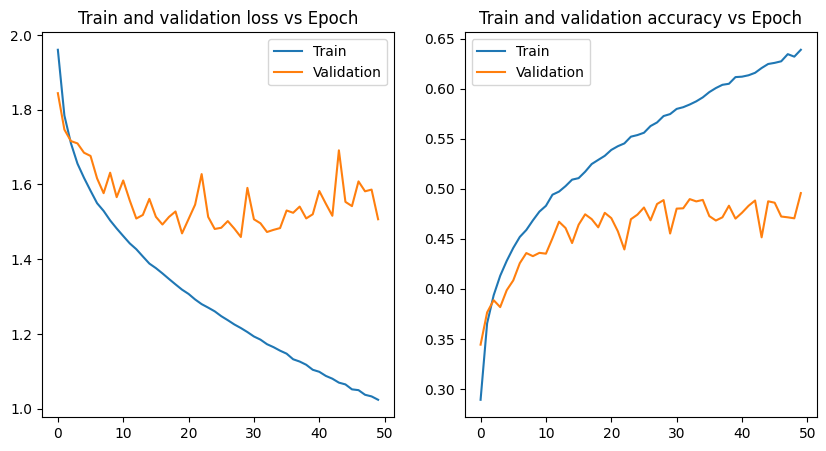

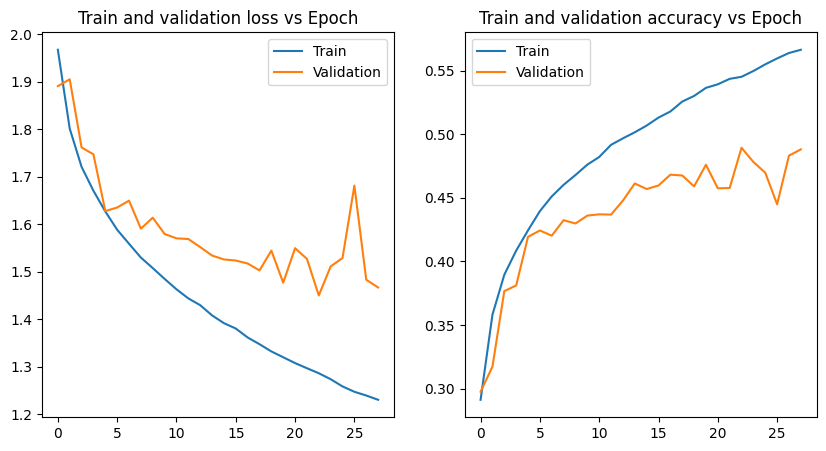

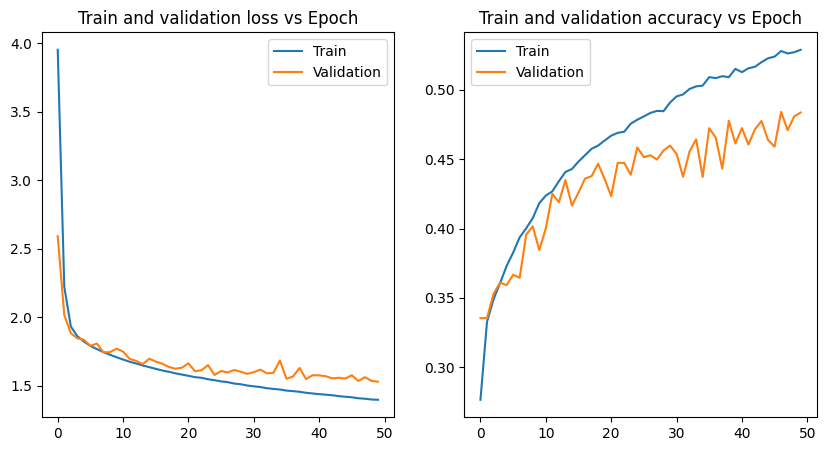

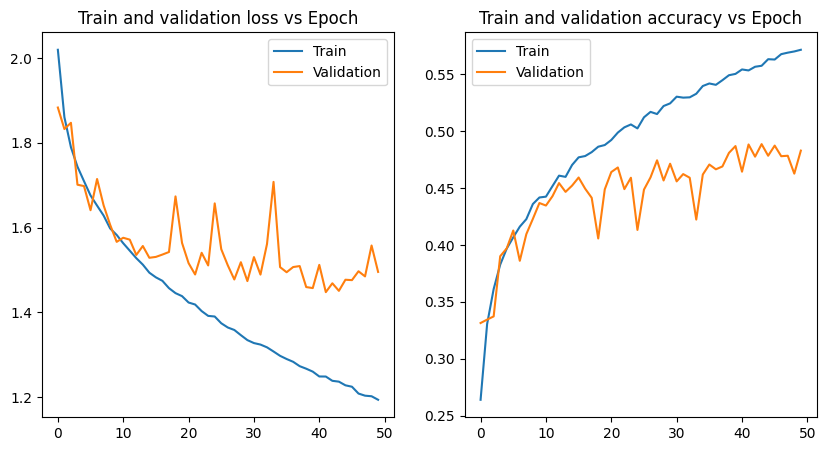

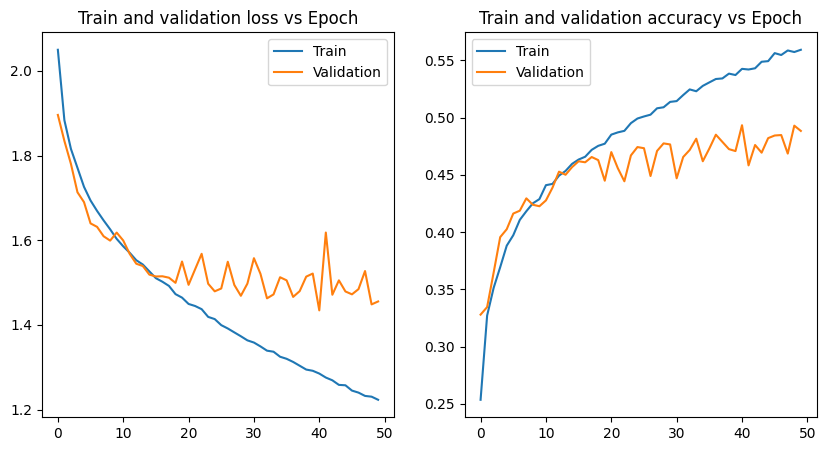

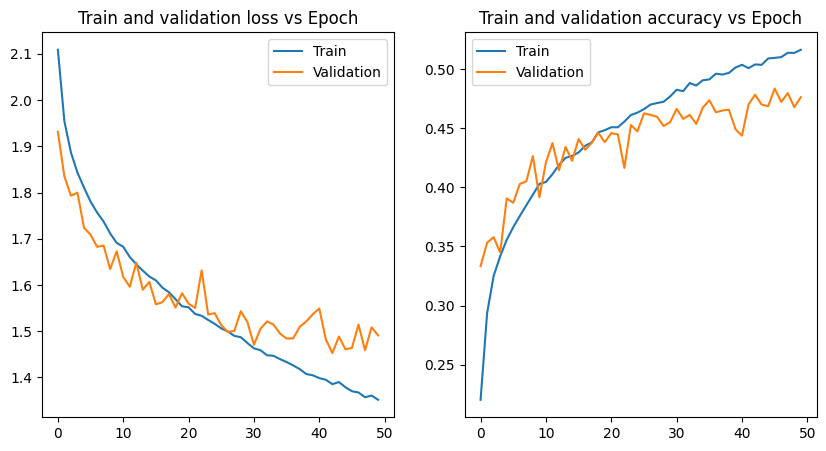

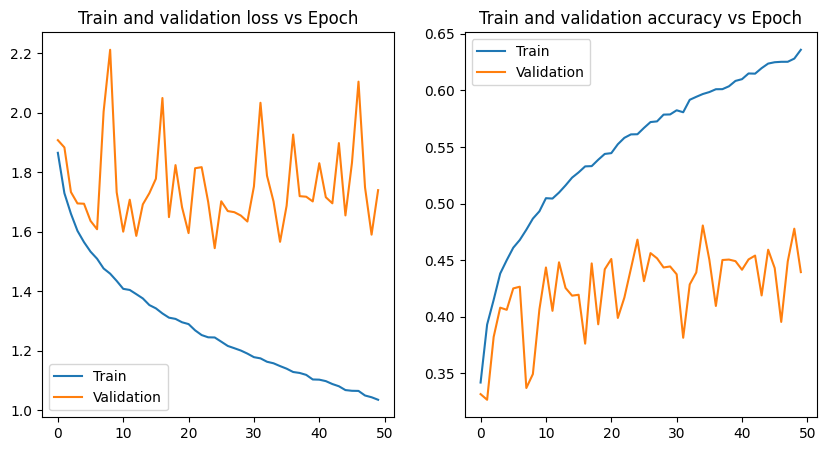

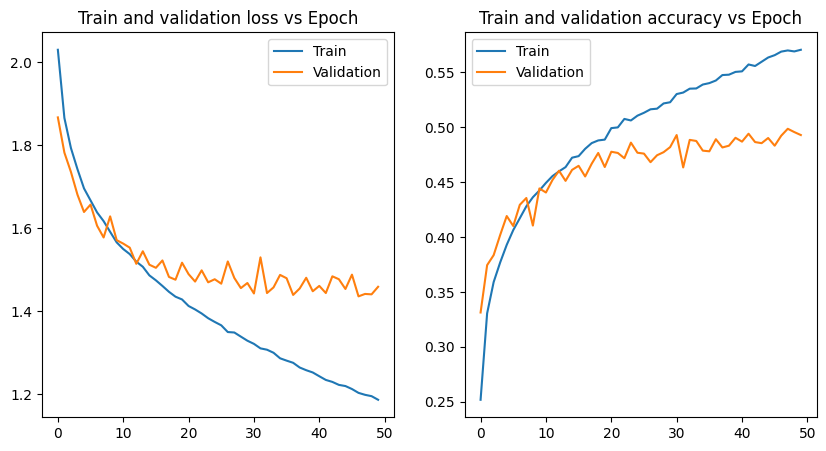

In [26]:
for name,history in histories.items():
  figures[name] = plot_loss_accuracy(history)

## Save the histories,durations and figures and the best model

In [27]:
def save_models(models):
  os.mkdir("/kaggle/working/models")
  for model_name,model in models.items():
    model.save(f'/kaggle/working/models/{model_name}.keras')

In [28]:
save_models(models)

In [29]:
def histories2df(histories):

  dfs = []

  for name,history in histories.items():
    history_df = pd.DataFrame(history.history)
    history_df['model'] = [name for _ in range(len(history_df))]
    dfs.append(history_df)

  return pd.concat(dfs)

In [30]:
histories_df = histories2df(histories)

In [31]:
histories_df.to_csv('/kaggle/working/histories_df.csv', index=False)

In [32]:
durations_serie = pd.Series(durations)
durations_serie

Mini-Batch SGD                             102.652152
Mini-Batch SGD + Early Stopping             57.742547
Mini-Batch SGD With L2 Nomralization       100.922874
Mini-Batch SGD With Dropout Rate = 0.2     105.407015
Mini-Batch SGD With Dropout Rate = 0.3     105.240382
Mini-Batch SGD With Dropout Rate = 0.5     106.039060
Mini-Batch SGD With Batch Normalization    107.224656
Random Search                              187.643153
dtype: float64

In [33]:
durations_serie.to_csv('/kaggle/working/durations.csv')

In [34]:
def save_figures(figures, path : str, create_if_not_exists : bool=True):

  if create_if_not_exists and not os.path.exists(path):
    os.mkdir(path)

  if not create_if_not_exists and not os.path.exists(path):
    raise Exception(f"{path} folder doesn't exists")

  if not os.path.isdir(path):
    raise Exception(f"{path} is not a directory")

  for name, figure in figures.items():
    name = name.replace(' ','_')+'.png'
    fig_path = os.path.join(path, name)
    figure.savefig(fig_path)

In [35]:
save_figures(figures, path='/kaggle/working/figures')

In [36]:
shutil.make_archive('/kaggle/working/cifar10-result', 'zip', '/kaggle', 'working')

'/kaggle/working/cifar10-result.zip'